### Generative data

The goal here is to simulate data under a generative model so that we can then try to predict the parameter values using model fitting. We will fit a linear and hierarchical linear model in pymc3 following the methods outlined here: https://twiecki.io/blog/2014/03/17/bayesian-glms-3/ and in the pymc3 tutorials. 

In [1]:
import pandas as pd
import numpy as np
import toytree
import toyplot

### The phylogeny
We will simulate data on phylogeny with four clades that have different rates of evolution of reproductive incompatibility, colored below. 

In [63]:
tree = toytree.rtree.baltree(ntips=128, treeheight=30e6)
tree = tree.mod.node_slider(prop=0.7)

In [64]:
tree.draw(
    layout='d', 
    width=600,
    tip_labels=False,
    edge_colors=tree.get_edge_values_from_dict({
        248: "red",
        249: "orange",
        250: "green",
        251: "blue",
    }),
);

<svg class="toyplot-canvas-Canvas" height="250.0px" id="tf0a059dd12714f7580d5b3a0a300bba0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600.0 250.0" width="600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <g class="toyplot-Datum" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(40%,76.1%,64.7%);stroke-opacity:1.0" transform="translate(357.0866141732283, 173.84804458301562)

### Model 1: Linear accumulation of RI with time

We will model incompatibility as something that accumulates linearly with time since divergence, with the rate parameter varying among the four clades. The question is: "does genetic distance predict the level of genetic incompatibility between species?". To implement a hierarchical model we are additionally asking: "Does information about which clade the species are from improve estimation?"


$$ Y_{ij} = \beta_0 + (\beta_1 + \psi_i + \psi_j) X_{ij} + e $$

$ \beta_0$ = intercept    
$ \beta_1$ = slope  
$ X_{ij}$ = genetic divergence  
$ Y_{ij}$  = Reproductive incompatibility  
$ \psi$ = velocity of RI which interacts additively with other species $\psi$ to generate RI between a cross. A $\psi$>0 accumulates RI faster than average after controlling for genetic distance while a $\psi$<0 accumulates slower. 

In [177]:
# True param values
b0 = 0.01
b1 = 1.0 / 19e6
err = 0.15

In [187]:
# nodes at the crown of four major clades in the tree
velocities = {
    248: b1 / 2,     # fastest rate of RI (red)
    249: b1 / 5,     # fast rate of RI (orange)
    250: -b1 / 10,   # slow rate of RI (green)
    251: -b1 / 3,    # slowest frate of RI (blue)
}

In [188]:
# build full dictionary of velocities
allvelo = {}

# iterate over dictionary keys
for node in velocities:
    
    # get all descendants of the selected node
    idxs = tree.get_node_descendant_idxs(node)
    
    # update dictionary mapping velo to node
    allvelo.update({i: velocities[node] for i in idxs})

# update on tree
tree = tree.set_node_values("velocity", allvelo)

In [189]:
ndict = tree.get_feature_dict("idx", None)
for node, color in zip(velocities, ("red", "orange", "green", "blue")):
    for idx in tree.get_node_descendant_idxs(node):
        ndict[idx].color = color

### The data frame
To emulate real data we will collect random crosses between both closely related and distantly related species. 

In [190]:
def dist(tree, idx0, idx1):
    "returns the genetic distance between two nodes on a tree"
    ndict = tree.get_feature_dict('idx', None)
    return tree.treenode.get_distance(ndict[idx0], ndict[idx1])

In [191]:
np.random.seed(123)
ncrosses = 2500

# randomly choose tip idx numbers maternal and paternal
data = pd.DataFrame({
    "maternal": np.random.randint(0, tree.ntips, ncrosses),
    "paternal": np.random.randint(0, tree.ntips, ncrosses),
    "RI": np.zeros(ncrosses),
})

# get node feature dict
nodedict = tree.get_feature_dict("idx", None)

# iterate to fill RI values
for idx in data.index:
    
    # get node indices
    idx0 = data.loc[idx, "maternal"]
    idx1 = data.loc[idx, "paternal"]
    
    # get node velocities
    v0 = nodedict[idx0].velocity
    v1 = nodedict[idx1].velocity
    
    # generate error
    error = np.random.normal(0, err)
    
    # get RI
    ri = b0 + ((b1 + v0 + v1) * (dist(tree, idx0, idx1) / 2.0)) + error
    
    # normalize -- cannot be >1 or <0
    ri = max(0.0, min(1.0, ri))
    
    # store values
    data.loc[idx, "RI"] = ri
    data.loc[idx, "divtime"] = dist(tree, idx0, idx1) / 2.

# show 
data.head()

maternal  paternal        RI       divtime
0       126        13  1.000000  3.000000e+07
1       109        49  1.000000  3.000000e+07
2       126        16  1.000000  3.000000e+07
3        66        69  0.516189  1.132095e+07
4        92         4  1.000000  3.000000e+07

### Plot RI values by divergence

In [192]:
data["clade0"] = [ndict[i].color for i in data["maternal"]]
data["clade1"] = [ndict[i].color for i in data["paternal"]]

### Final data

Drop data points where the maternal and paternal organisms are the same one, since we randomly selected them. Then log transform the divergence time estimates to make for prettier plotting and simpler model fitting. 

In [193]:
fdata = data.drop(index=data[data.maternal == data.paternal].index)

In [196]:
fdata["logdiv"] = np.log(fdata["divtime"])

In [198]:
canvas = toyplot.Canvas(width=400, height=300)
axes = canvas.cartesian(
    xlabel="Divergence time",
    ylabel="Reprod. incomp.",
)
axes.scatterplot(
    fdata.divtime,
    fdata.RI,
    size=8,
    opacity=0.1,
    color=fdata.clade0.tolist(),
);
axes.x.ticks.show = True
axes.y.ticks.show = True

<svg class="toyplot-canvas-Canvas" height="300.0px" id="td099beb160fc488f821680c0fe70f731" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 400.0 300.0" width="400.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <g class="toyplot-Datum" style="fill:rgb(0%,0%,100%);fill-opacity:1.0;opacity:0.1;stroke:rgb(0%,0%,100%);stroke-opacity:1.0" transform="translate(198.53433503793025, 235.

In [202]:
fdata.describe()

maternal     paternal           RI       divtime       logdiv
count  2485.000000  2485.000000  2485.000000  2.485000e+03  2485.000000
mean     64.162173    64.164185     0.899658  2.581467e+07    17.029414
std      37.447051    37.035850     0.206928  5.662394e+06     0.310927
min       0.000000     0.000000     0.000000  1.974883e+06    14.496020
25%      30.000000    32.000000     0.947120  2.362446e+07    16.977793
50%      65.000000    64.000000     1.000000  3.000000e+07    17.216708
75%      97.000000    96.000000     1.000000  3.000000e+07    17.216708
max     127.000000   127.000000     1.000000  3.000000e+07    17.216708

### Individual model
This model tries to fit a single intercept and slope to the RI data. 

In [200]:
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [201]:
with pm.Model() as m0:
    
    # model parameters
    b0 = pm.Normal("alpha", mu=0, sd=1)
    b1 = pm.Normal("beta", mu=15, sd=5)
    er = pm.HalfCauchy("err", beta=1)
    
    # linear model
    ri = b0 + b1 * fdata["logdiv"]
    
    # the data likelihoood w/ normally distributed error
    y_lik = pm.Normal("lik", mu=ri, sd=er, observed=fdata.RI)

    # inference
    trace = pm.sample(tune=10000, draws=10000);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [err, beta, alpha]
Sampling 4 chains, 0 divergences:   2%|▏         | 1507/80000 [00:03<02:37, 497.55draws/s] 


RuntimeError: Chain 3 failed.

/home/deren/miniconda3/envs/py36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/deren/miniconda3/envs/py36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/deren/miniconda3/envs/py36/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


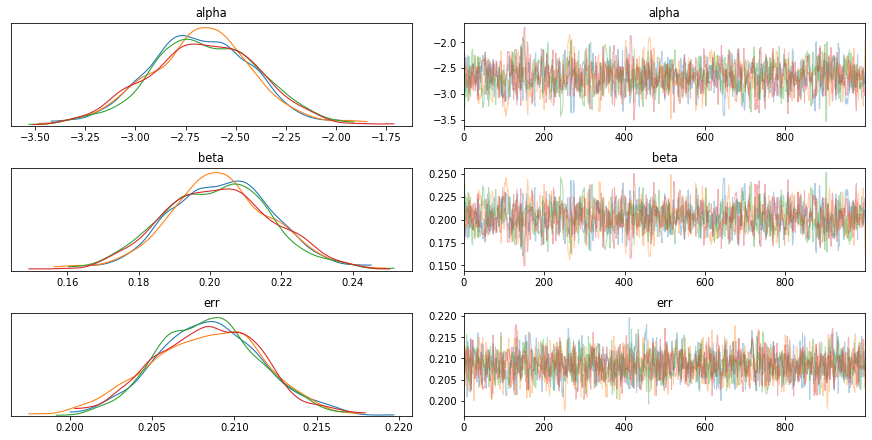

In [106]:
pm.traceplot(trace);

In [ ]:
# takes about 45 minutes
indiv_traces = {}

for county_name in county_names:
    
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_data = c_data.reset_index(drop=True)
    
    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values
    
    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)
    
        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)
    
        # Linear model
        radon_est = a + b * c_floor_measure
    
        # Data likelihood
        y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[county_name] = trace